In [ ]:
import os
import cv2
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Useful Functions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples_per_class(images, labels, num_classes=4, samples_per_class=3, figsize_per_image=(3,3), cmap='gray'):
    plt.figure(figsize=(samples_per_class * figsize_per_image[0], num_classes * figsize_per_image[1]))

    for class_label in range(num_classes):

        class_indices = [i for i, lbl in enumerate(labels) if lbl == class_label]
        if len(class_indices) < samples_per_class:
            print(f"Warning: class {class_label} has only {len(class_indices)} images.")
            selected_indices = class_indices
        else:
            selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)

        for i, idx in enumerate(selected_indices):
            plt.subplot(num_classes, samples_per_class, class_label * samples_per_class + i + 1)
            plt.imshow(images[idx], cmap=cmap)
            plt.title(f"Class {class_label}", fontsize=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:

def show_image_grid(images, title="", cols=2):
    import matplotlib.pyplot as plt
    if not images:
        print(f"لا توجد صور لعرضها: {title}")
        return

    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(cols * 4, rows * 4))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

## Loading after preprocessing 1

In [ ]:
import numpy as np
import os


paths = {
    "train": "/kaggle/input/oa-3folders/OA_train",
    "val": "/kaggle/input/oa-3folders/OA_val",
    "test": "/kaggle/input/oa-3folders/OA_test"
}


def load_npy_dataset(folder_path):
    X_path = os.path.join(folder_path, "X_all.npy")
    y_path = os.path.join(folder_path, "y_all.npy")

    X = np.load(X_path)
    y = np.load(y_path)


    classes = np.unique(y)
    return X, y, classes


X_train, y_train, classes_train = load_npy_dataset(paths["train"])
X_val, y_val, classes_val = load_npy_dataset(paths["val"])
X_test, y_test, classes_test = load_npy_dataset(paths["test"])


def print_dataset_info(name, X, y, classes):
    print(f"{name}:")
    print(f"  Total images: {len(X)}")
    for cls in classes:
        count = np.sum(y == cls)
        print(f"  Class {cls}: {count} images")
    print("")

print_dataset_info("X_train/y_train", X_train, y_train, classes_train)
print_dataset_info("X_val/y_val", X_val, y_val, classes_val)
print_dataset_info("X_test/y_test", X_test, y_test, classes_test)


X_train/y_train:
  Total images: 5981
  Class 0: 2888 images
  Class 1: 1919 images
  Class 2: 957 images
  Class 3: 217 images

X_val/y_val:
  Total images: 672
  Class 0: 328 images
  Class 1: 212 images
  Class 2: 106 images
  Class 3: 26 images

X_test/y_test:
  Total images: 1360
  Class 0: 639 images
  Class 1: 447 images
  Class 2: 223 images
  Class 3: 51 images



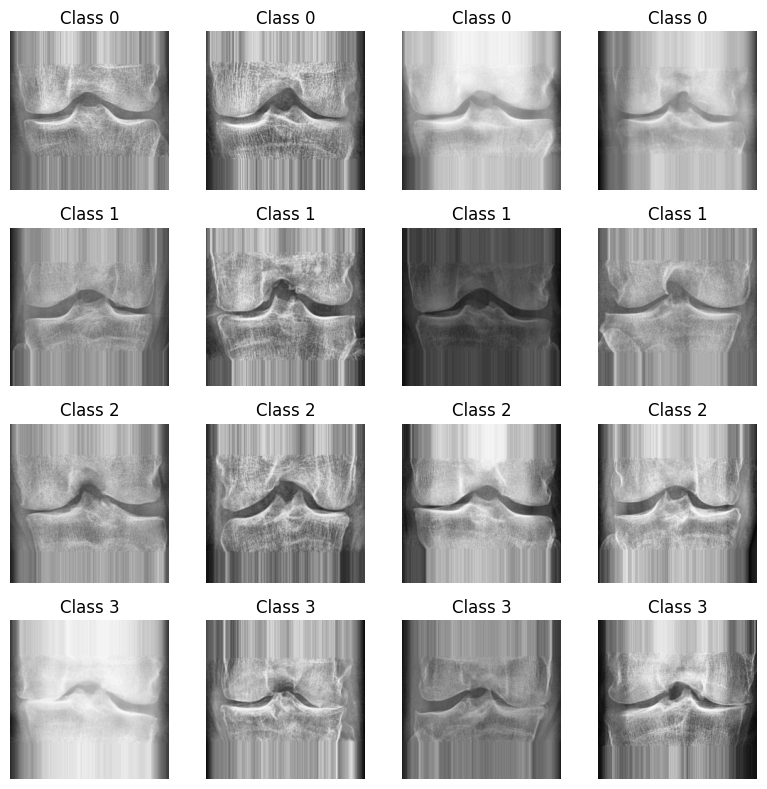

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

def show_balanced_samples(X, y, num_classes=4, samples_per_class=4):
    """

    """
    plt.figure(figsize=(samples_per_class * 2, num_classes * 2))

    for class_label in range(num_classes):
        class_idxs = np.where(y == class_label)[0]
        selected_idxs = np.random.choice(class_idxs, size=samples_per_class, replace=False)

        for i, idx in enumerate(selected_idxs):
            plt_idx = class_label * samples_per_class + i + 1
            img = X[idx]

            if img.shape[-1] == 1:
                img = img.squeeze(-1)

            plt.subplot(num_classes, samples_per_class, plt_idx)
            plt.imshow(img.astype(np.uint8))
            plt.title(f"Class {class_label}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()


show_balanced_samples(X_train, y_train, num_classes=4, samples_per_class=4)


## Splitting

In [ ]:
import numpy as np

total_val_test = len(X_val) + len(X_test)
new_count_each = total_val_test // 2

needed_for_val = new_count_each - len(X_val)
if needed_for_val > 0:
    classes = np.unique(y_test)
    indices_to_move = []

    for cls in classes:
        cls_indices = np.where(y_test == cls)[0]
        cls_ratio = len(cls_indices) / len(y_test)
        num_to_take = int(round(cls_ratio * needed_for_val))
        selected = np.random.choice(cls_indices, size=min(num_to_take, len(cls_indices)), replace=False)
        indices_to_move.extend(selected)

    X_val = np.concatenate([X_val, X_test[indices_to_move]])
    y_val = np.concatenate([y_val, y_test[indices_to_move]])

    mask = np.ones(len(X_test), dtype=bool)
    mask[indices_to_move] = False
    X_test = X_test[mask]
    y_test = y_test[mask]

print("Updated sizes:")
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

for cls in np.unique(y_val):
    print(f"Class {cls} in val: {np.sum(y_val==cls)}")
for cls in np.unique(y_test):
    print(f"Class {cls} in test: {np.sum(y_test==cls)}")


Updated sizes:
X_val: (1016, 224, 224, 3) y_val: (1016,)
X_test: (1016, 224, 224, 3) y_test: (1016,)
Class 0 in val: 490
Class 1 in val: 325
Class 2 in val: 162
Class 3 in val: 39
Class 0 in test: 477
Class 1 in test: 334
Class 2 in test: 167
Class 3 in test: 38


## Balancing

In [ ]:
import numpy as np
import random
from collections import Counter

def horizontal_flip(image):
    return np.fliplr(image)

def adjust_contrast(image, factor=1.5):
    image = image.astype(np.float32)
    mean = np.mean(image)
    return np.clip((image - mean) * factor + mean, 0, 255).astype(np.uint8)

def add_noise(image, noise_level=10):
    noise = np.random.normal(0, noise_level, image.shape)
    return np.clip(image + noise, 0, 255).astype(np.uint8)

def augment_image(image):
    funcs = [horizontal_flip,
             lambda img: adjust_contrast(img, factor=random.uniform(0.7, 1.5)),
             lambda img: add_noise(img, noise_level=random.uniform(5, 20))]
    func = random.choice(funcs)
    return func(image)

def balance_data_custom(X, y, max_per_class=2000):
    class_counts = Counter(y)
    classes = np.unique(y)

    X_balanced = []
    y_balanced = []

    for c in classes:
        idxs = np.where(y == c)[0]
        X_class = X[idxs]
        y_class = y[idxs]

        count = len(idxs)

        if count > max_per_class:

            selected_idxs = np.random.choice(count, max_per_class, replace=False)
            X_combined = X_class[selected_idxs]
            y_combined = y_class[selected_idxs]

        elif count < max_per_class:
            num_needed = max_per_class - count
            X_aug = []
            for _ in range(num_needed):
                img = random.choice(X_class)
                aug_img = augment_image(img)
                X_aug.append(aug_img)

            y_aug = np.full(len(X_aug), c)
            X_combined = np.concatenate([X_class, X_aug])
            y_combined = np.concatenate([y_class, y_aug])

        else:

            X_combined = X_class
            y_combined = y_class

        X_balanced.append(X_combined)
        y_balanced.append(y_combined)


    X_final = np.concatenate(X_balanced)
    y_final = np.concatenate(y_balanced)

    indices = np.arange(len(X_final))
    np.random.shuffle(indices)

    return X_final[indices], y_final[indices]

X_train_resampled, y_train_resampled = balance_data_custom(X_train, y_train, max_per_class=1900)

In [ ]:
print("\n✅ بعد الموازنة:")
print(f"X_train_resampled shape: {X_train_resampled.shape}")
print("فئات بعد الموازنة:", Counter(y_train_resampled))


✅ بعد الموازنة:
X_train_resampled shape: (7600, 224, 224, 3)
فئات بعد الموازنة: Counter({1: 1900, 2: 1900, 0: 1900, 3: 1900})


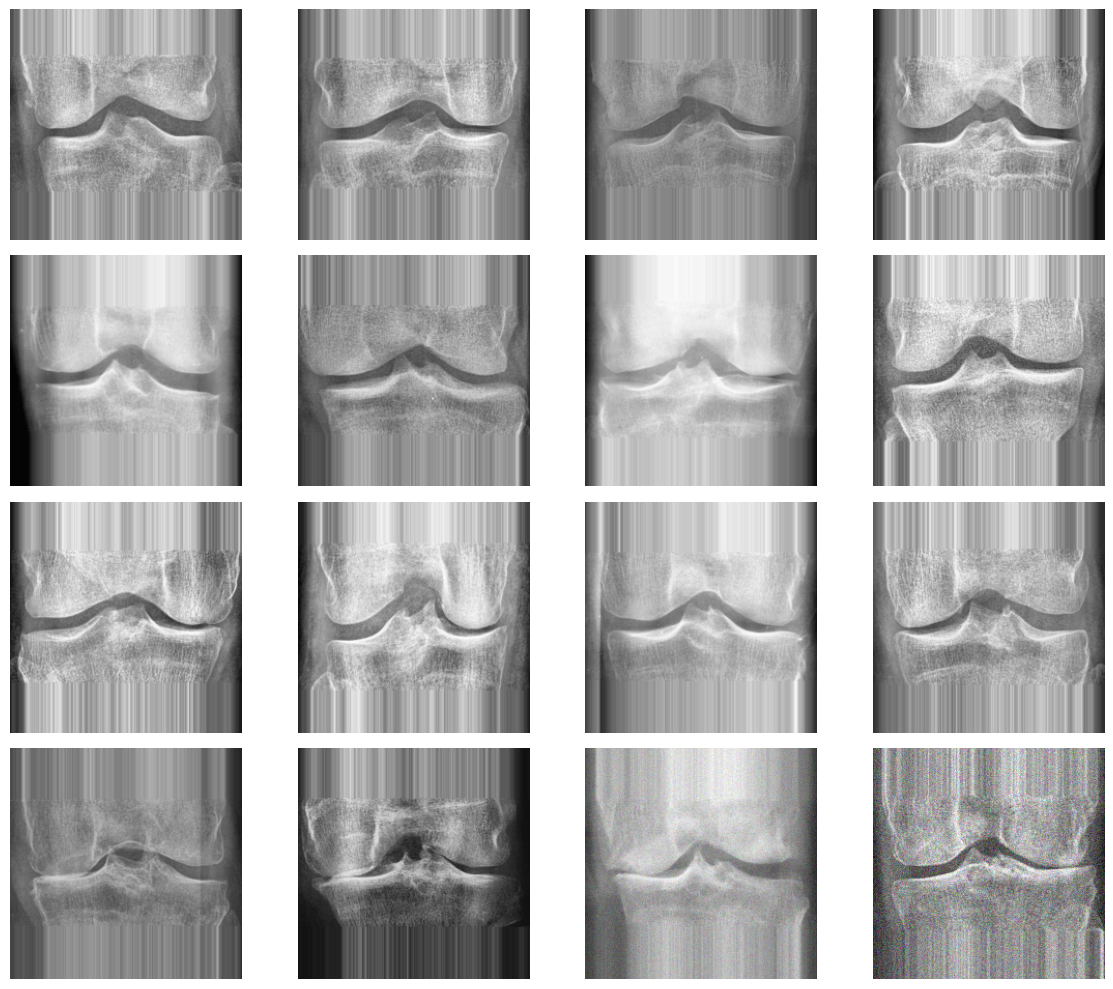

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def show_balanced_samples(X, y, num_classes=4, samples_per_class=4):
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(12, 10))

    for class_idx in range(num_classes):

        class_indices = np.where(y == class_idx)[0]

        selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)

        for i, idx in enumerate(selected_indices):
            ax = axes[class_idx, i]
            image = X[idx]

            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)
            ax.imshow(image)
            ax.axis('off')
            if i == 0:
                ax.set_ylabel(f"فئة {class_idx}", fontsize=12)

    plt.tight_layout()
    plt.show()
show_balanced_samples(X_train_resampled, y_train_resampled, num_classes=4, samples_per_class=4)

## Preparing & Training

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

is_normalized = (np.min(X_train_resampled) >= 0.0 and np.max(X_train_resampled) <= 1.0)
print("✅ Are images normalized already? ", is_normalized)

num_classes = len(set(y_train_resampled))
print("✅ Number of classes:", num_classes)

if is_normalized:
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator()
else:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    X_train_resampled, y_train_resampled, batch_size=32, shuffle=True
)
validation_generator = val_datagen.flow(
    X_val, y_val, batch_size=32, shuffle=False
)


✅ Are images normalized already?  False
✅ Number of classes: 4


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

num_classes = 4

base_model = EfficientNetB3(
    weights=None,
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.load_weights('/kaggle/input/efficientnetb3-notop-weights/efficientnetb3_notop.weights.h5')

base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path = "/kaggle/working/EfficientNetB3_last_model.keras"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

num_epochs = 10

history = model.fit(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=1,
    callbacks=[checkpoint]
)


2025-08-19 13:36:20.404356: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5919 - loss: 0.9085 
Epoch 1: val_accuracy improved from -inf to 0.15945, saving model to /kaggle/working/EfficientNetB3_last_model.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 2755s 11s/step - accuracy: 0.5923 - loss: 0.9078 - val_accuracy: 0.1594 - val_loss: 1.8014
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7785 - loss: 0.5143 
Epoch 2: val_accuracy improved from 0.15945 to 0.48327, saving model to /kaggle/working/EfficientNetB3_last_model.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 2634s 11s/step - accuracy: 0.7786 - loss: 0.5142 - val_accuracy: 0.4833 - val_loss: 1.1936
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8146 - loss: 0.4339 
Epoch 3: val_accuracy did not improve from 0.48327
238/238 ━━━━━━━━━━━━━━━━━━━━ 2603s 11s/step - accuracy: 0.8147 - loss: 0.4339 - val_accuracy: 0.2874 - val_loss: 1.3883
Epoch 4/10
116/238 ━━━━━━━━━━━━━━━━━━━━ 21:37 11s/step - accuracy: 0.8382 - loss: 0.3978

In [ ]:
import pickle

with open("/kaggle/working/efficientnetb3_history1.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("📦 Saved history to history.pkl")


📦 Saved history to history.pkl


In [ ]:
model.save("eff_model_1.keras")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


previous_model_path = "/kaggle/input/eff-model-1/eff_model_1.keras"


model = load_model(previous_model_path)


def lr_schedule(epoch, lr):
    if epoch == 1:
        return 5e-4
    elif epoch == 7:
        return 5e-5
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)


new_checkpoint_path = "/kaggle/working/EfficientNetB3_model_2.keras"
checkpoint = ModelCheckpoint(
    filepath=new_checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

model.compile(
    optimizer=Adam(learning_rate=5e-4), lr_schedule
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=1,
    callbacks=[checkpoint, lr_scheduler]
)


2025-08-19 23:45:52.430923: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8863 - loss: 0.2821 
Epoch 1: val_accuracy improved from -inf to 0.22244, saving model to /kaggle/working/EfficientNetB3_model_2.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 3454s 14s/step - accuracy: 0.8863 - loss: 0.2821 - val_accuracy: 0.2224 - val_loss: 1.9571 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005.
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8870 - loss: 0.2833 
Epoch 2: val_accuracy did not improve from 0.22244
238/238 ━━━━━━━━━━━━━━━━━━━━ 3213s 14s/step - accuracy: 0.8870 - loss: 0.2832 - val_accuracy: 0.1565 - val_loss: 4.0948 - learning_rate: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8877 - loss: 0.2727 
Epoch 3: val_accuracy did not improve from 0.22244
23

In [ ]:
model.save("EfficientNetB3_model_22.keras")

In [ ]:
import pickle

with open("/kaggle/working/efficientnetb3_history2.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("📦 Saved history to history2.pkl")


📦 Saved history to history2.pkl


32/32 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step
Test Accuracy: 0.8503937007874016
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       477
           1       0.88      0.66      0.76       334
           2       0.88      0.90      0.89       167
           3       0.90      0.92      0.91        38

    accuracy                           0.85      1016
   macro avg       0.87      0.86      0.86      1016
weighted avg       0.85      0.85      0.84      1016



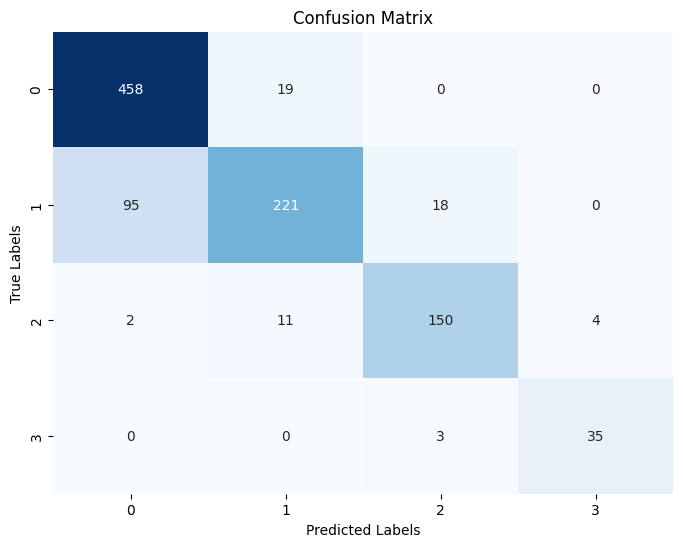

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score



#model = load_model("")

X_test = X_test.astype('float32') / 255.0


if len(X_test.shape) == 3:
    X_test = np.expand_dims(X_test, axis=-1)


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


y_true_classes = y_test


accuracy = accuracy_score(y_true_classes, y_pred_classes)
report = classification_report(y_true_classes, y_pred_classes)

print("Test Accuracy:", accuracy)
print("Classification Report:")
print(report)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true_classes, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# دفعة 3

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


previous_model_path = "/kaggle/input/efficientnetb3-model-2/EfficientNetB3_model_2.keras"


model = load_model(previous_model_path)


def lr_schedule(epoch, lr):
    if epoch < 2:
        return 5e-5
    elif epoch < 7:
        return 1e-5
    else:
        return 5e-6

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)


new_checkpoint_path = "/kaggle/working/EfficientNetB3_model_next.keras"
checkpoint = ModelCheckpoint(
    filepath=new_checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)


model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


num_epochs = 10


history3 = model.fit(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=1,
    callbacks=[checkpoint, lr_scheduler]
)


2025-08-20 09:02:51.572164: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 5e-05.
Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9564 - loss: 0.1182 
Epoch 1: val_accuracy improved from -inf to 0.69094, saving model to /kaggle/working/EfficientNetB3_model_next.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 2842s 11s/step - accuracy: 0.9564 - loss: 0.1182 - val_accuracy: 0.6909 - val_loss: 0.8869 - learning_rate: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 5e-05.
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9525 - loss: 0.1206 
Epoch 2: val_accuracy improved from 0.69094 to 0.79823, saving model to /kaggle/working/EfficientNetB3_model_next.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 2680s 11s/step - accuracy: 0.9525 - loss: 0.1205 - val_accuracy: 0.7982 - val_loss: 0.5975 - learning_rate: 5.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-05.
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9575 - loss: 0.1191 
Epoch 3: val_a

32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step
Test Accuracy: 0.9320866141732284
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       477
           1       0.92      0.89      0.90       334
           2       0.91      0.98      0.94       167
           3       0.95      0.97      0.96        38

    accuracy                           0.93      1016
   macro avg       0.93      0.95      0.94      1016
weighted avg       0.93      0.93      0.93      1016



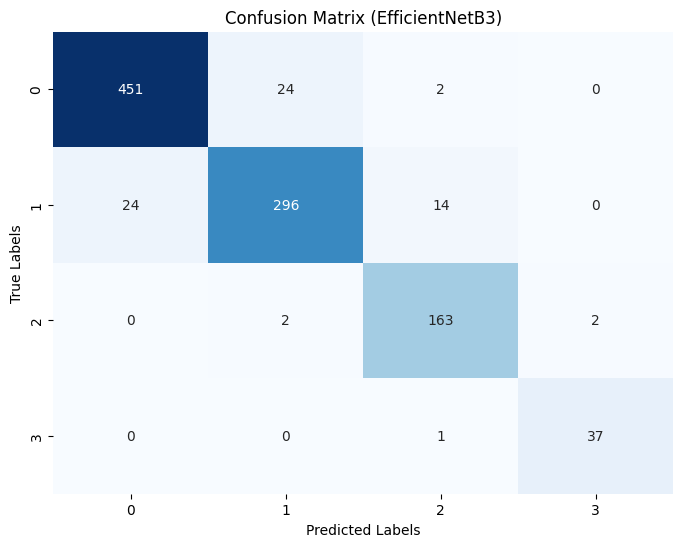

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score


model = load_model("/kaggle/input/efficientnetb3-model-3/EfficientNetB3_model_3.keras")

X_test = X_test.astype('float32') / 255.0


if len(X_test.shape) == 3:
    X_test = np.expand_dims(X_test, axis=-1)


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


y_true_classes = y_test


accuracy = accuracy_score(y_true_classes, y_pred_classes)
report = classification_report(y_true_classes, y_pred_classes)

print("Test Accuracy:", accuracy)
print("Classification Report:")
print(report)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true_classes, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (EfficientNetB3)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
